#Code

In [2]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.7 MB/s eta 0:00:00


In [3]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torchvision
from transformers import AutoModel, AutoImageProcessor
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import faiss
from tqdm import tqdm
import pandas as pd
import random

random.seed(42)
save_route = "/content/drive/MyDrive/Deep Learning/final_project/20242R0136COSE47402/FinalProject/"

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Model

In [6]:
from transformers import AutoProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [7]:
from transformers import AutoImageProcessor, AutoModel

dino_model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

In [8]:
from transformers import AutoImageProcessor, ViTModel

vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


## Dataset

### kaggle

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hmendonca/disc21")

print("Path to dataset files:", path)

100%|██████████| 31.7G/31.7G [17:55<00:00, 31.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4


### Dataframe

In [11]:
data_df = pd.read_csv("/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/final_ground_truth.csv")

data_df = pd.DataFrame({
    "query": ["Q50017"] + data_df['Q50017'].tolist(),
    "reference": ["R277156"] + data_df['R277156'].tolist()
})

In [12]:
data_df

,query,reference
0,Q50017,R277156
1,Q50019,R294758
2,Q50025,R922600
3,Q50034,R360860
4,Q50036,R105649
...,...,...
9995,Q99970,R263204
9996,Q99972,R336410
9997,Q99973,R759408
9998,Q99975,R726991


In [13]:
query_folder_path = "/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/final_queries/images/final_queries"
reference_folder_path = "/root/.cache/kagglehub/datasets/hmendonca/disc21/versions/4/references_0/images/references"

In [14]:
data_df['numeric_reference'] = data_df['reference'].str.extract(r'R(\d+)').astype(int)
filtered_df = data_df[data_df['numeric_reference']<50000]

In [15]:
query_list = filtered_df['query'].tolist()

In [16]:
num_list = filtered_df['numeric_reference'].tolist()
full_list = [i for i in range(0,50000)]
full_list = list(set(full_list)-set(num_list))
sampled_list = random.sample(full_list, 9500)
reference_num = sampled_list +num_list

reference_list = ["R"+str(number).zfill(6) for number in reference_num]

In [17]:
filtered_df

,query,reference,numeric_reference
12,Q50060,R003513,3513
19,Q50095,R029638,29638
34,Q50186,R038042,38042
44,Q50229,R040485,40485
77,Q50386,R037975,37975
...,...,...,...
9909,Q99525,R030731,30731
9912,Q99538,R043554,43554
9956,Q99763,R034725,34725
9985,Q99915,R044043,44043


In [18]:
filtered_df=filtered_df.reset_index()
final_df = filtered_df[["query", "reference"]]

### Dataloader

In [19]:
def query_dataloader(processor):
  query_images = []
  for file in tqdm(query_list):
      image = Image.open(os.path.join(query_folder_path,file+'.jpg'))
      image = processor(images = image, return_tensors="pt").pixel_values
      query_images.append(image)
  query_loader = torch.utils.data.DataLoader(query_images, batch_size=32)
  return query_loader

def reference_dataloader(processor):
  reference_images = []
  for file in tqdm(reference_list):
      image = Image.open(os.path.join(reference_folder_path,file+'.jpg'))
      image = processor(images = image, return_tensors="pt").pixel_values
      reference_images.append(image)
  reference_loader = torch.utils.data.DataLoader(reference_images, batch_size=32)
  return reference_loader

#image embeddings&FAISS

In [20]:
def normalizeL2(embeddings):
    vector = embeddings.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    return vector

def make_embeddings(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

##CLIP

In [15]:
clip_reference = reference_dataloader(clip_processor)

100%|██████████| 10000/10000 [04:09<00:00, 40.02it/s]


In [16]:
index_clip = faiss.IndexFlatIP(512)

In [17]:
for img in tqdm(clip_reference):
    img = img.to(device).squeeze()
    clip_features = clip_model.get_image_features(img)
    make_embeddings(clip_features,index_clip)

100%|██████████| 313/313 [01:47<00:00,  2.92it/s]


In [18]:
faiss.write_index(index_clip,save_route+"clip.index")

## DinoV2

In [15]:
index_dino = faiss.IndexFlatIP(768)

In [16]:
dino_reference = reference_dataloader(dino_processor)

100%|██████████| 10000/10000 [03:30<00:00, 47.40it/s]


In [17]:
for img in tqdm(dino_reference):
    img = img.to(device).squeeze()
    dino_features = dino_model(img).last_hidden_state.mean(dim=1)
    make_embeddings(dino_features,index_dino)

100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


In [18]:
faiss.write_index(index_dino,save_route+"dino.index")

## ViT

In [15]:
index_vit = faiss.IndexFlatIP(768)

In [16]:
vit_reference = reference_dataloader(vit_processor)

100%|██████████| 10000/10000 [02:43<00:00, 61.19it/s]


In [19]:
for img in tqdm(vit_reference):
    img = img.to(device).squeeze()
    vit_features = vit_model(img).last_hidden_state[:, 0, :].squeeze()
    make_embeddings(vit_features,index_vit)

100%|██████████| 313/313 [01:46<00:00,  2.95it/s]


In [20]:
faiss.write_index(index_vit,save_route+"vit.index")

#Evaluate simiarity performance of the model

## CLIP

In [21]:
clip_query = query_dataloader(clip_processor)

100%|██████████| 500/500 [00:11<00:00, 41.97it/s]


In [23]:
clip_distance_list = np.empty((0, 3))
clip_index_list=np.empty((0, 3))

for img in tqdm(clip_query):
    img = img.to(device).squeeze()
    features = clip_model.get_image_features(img)
    image_features = normalizeL2(features)
    index_clip = faiss.read_index(save_route+"clip.index")
    d_clip,i_clip = index_clip.search(image_features,3)
    clip_distance_list = np.concatenate((clip_distance_list,d_clip), axis=0)
    clip_index_list = np.concatenate((clip_index_list,i_clip), axis=0)

100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


In [24]:
clip_correct_top3 =[]
clip_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in clip_index_list[i]]:
    clip_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(clip_index_list[i][0])]:
    clip_correct.append(i)

In [25]:
len(clip_correct_top3), len(clip_correct)

(192, 163)

## DINOv2

In [26]:
dino_query = query_dataloader(dino_processor)

100%|██████████| 500/500 [00:09<00:00, 54.06it/s]


In [27]:
dino_distance_list = np.empty((0, 3))
dino_index_list=np.empty((0, 3))

for img in tqdm(dino_query):
    img = img.to(device).squeeze()
    features = dino_model(img).last_hidden_state.mean(dim=1)
    image_features = normalizeL2(features)
    index_dino = faiss.read_index(save_route+"dino.index")
    d_dino,i_dino = index_dino.search(image_features,3)
    dino_distance_list = np.concatenate((dino_distance_list,d_dino), axis=0)
    dino_index_list = np.concatenate((dino_index_list,i_dino), axis=0)

100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


In [28]:
dino_correct_top3 =[]
dino_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in dino_index_list[i]]:
    dino_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(dino_index_list[i][0])]:
    dino_correct.append(i)

In [29]:
len(dino_correct_top3), len(dino_correct)

(323, 296)

## ViT

In [30]:
vit_query = query_dataloader(vit_processor)

100%|██████████| 500/500 [00:08<00:00, 57.58it/s]


In [33]:
vit_distance_list = np.empty((0, 3))
vit_index_list=np.empty((0, 3))

for img in tqdm(vit_query):
    img = img.to(device).squeeze()
    features = vit_model(img).last_hidden_state.mean(dim=1)
    image_features = normalizeL2(features)
    index_vit = faiss.read_index(save_route+"vit.index")
    d_vit,i_vit = index_vit.search(image_features,3)
    vit_distance_list = np.concatenate((vit_distance_list,d_vit), axis=0)
    vit_index_list = np.concatenate((vit_index_list,i_vit), axis=0)

100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


In [35]:
vit_correct_top3 =[]
vit_correct = []
for i in range(len(query_list)):
  if final_df["reference"][i] in [reference_list[int(idx)] for idx in vit_index_list[i]]:
    vit_correct_top3.append(i)
  if final_df["reference"][i] == reference_list[int(vit_index_list[i][0])]:
    vit_correct.append(i)

In [36]:
len(vit_correct_top3), len(vit_correct)

(225, 199)

## Visualize

### compare the performance

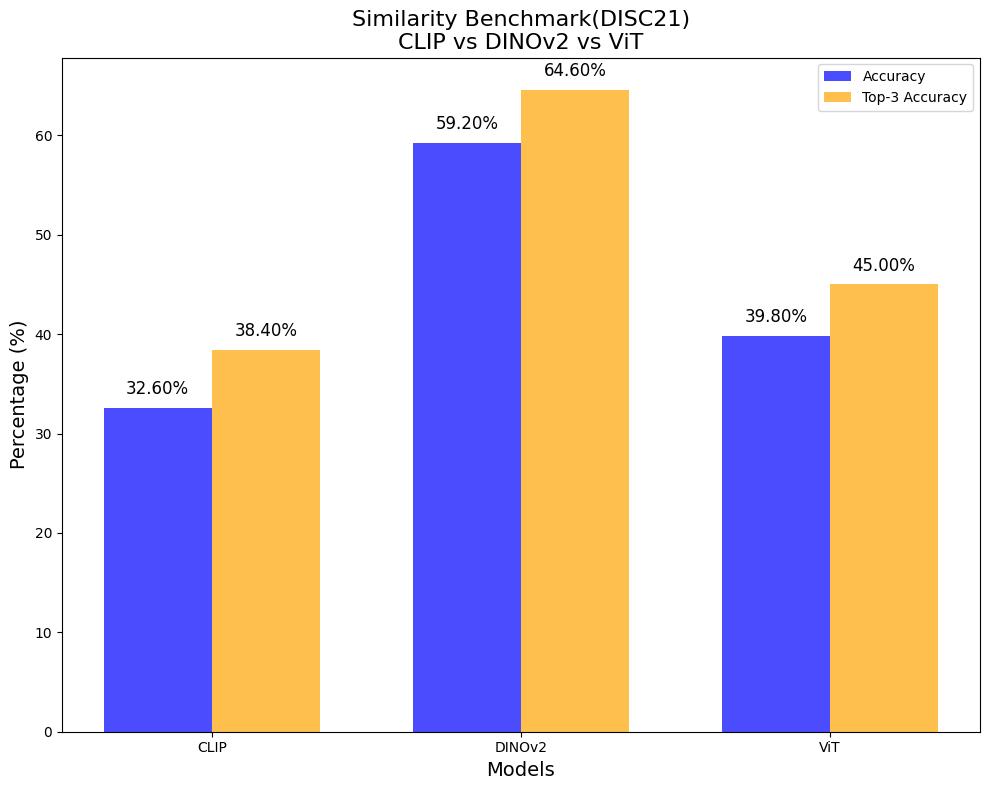

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 정의
models = ['CLIP', 'DINOv2', 'ViT']
accuracy = [100*len(clip_correct)/500, 100*len(dino_correct)/500, 100*len(vit_correct)/500]
top_3_accuracy = [100*len(clip_correct_top3)/500, 100*len(dino_correct_top3)/500, 100*len(vit_correct_top3)/500]

# x 위치 설정
x = np.arange(len(models))
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 8))

# Accuracy와 Top-3 Accuracy 막대 생성
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, top_3_accuracy, width, label='Top-3 Accuracy', color='orange', alpha=0.7)

# 제목 및 축 레이블 설정
ax.set_title('Similarity Benchmark(DISC21)\nCLIP vs DINOv2 vs ViT', fontsize=16)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 값 표시
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

add_labels(bars1)
add_labels(bars2)

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### compare the result

In [59]:
def visualize_similar_images(query_image_path,answer_image_path, retrieved_images):

  fig, axes = plt.subplots(3, 5, figsize=(20, 12))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(3):
      query_image_path = query_image_path
      model_name= retrieved_images[i][0]
      images = retrieved_images[i][1:4]

      query_image = Image.open(query_image_path).convert("RGB")
      axes[i, 0].imshow(query_image)
      axes[i, 0].axis("off")
      axes[i, 0].set_title(f"{model_name}\nQuery Image")

      answer_image = Image.open(answer_image_path).convert("RGB")
      axes[i, 1].imshow(answer_image)
      axes[i, 1].axis("off")
      axes[i, 1].set_title(f"{model_name}\nAnswer Image")

      for col, img_info in enumerate(images, start=2):
          img = Image.open(img_info["path"]).convert("RGB")
          similarity = img_info["similarity"]

          axes[i, col].imshow(img)
          axes[i, col].axis("off")
          axes[i, col].set_title(f"Similarity:\n{similarity:.1f}%")

  plt.tight_layout()
  plt.show()


In [82]:
all_list = [i for i in range(500)]
all_correct = list(set(clip_correct) & set(dino_correct)&set(vit_correct))
clip_dino = list(set(clip_correct) & set(dino_correct)-set(all_correct))
clip_vit = list(set(clip_correct) & set(vit_correct)-set(all_correct))
dino_vit = list(set(dino_correct) & set(vit_correct)-set(all_correct))
only_clip = list(set(clip_correct) - set(dino_correct) - set(vit_correct))
only_dino = list(set(dino_correct) - set(clip_correct)-set(vit_correct))
only_vit = list(set(vit_correct) - set(dino_correct)-set(clip_correct))
non_correct = list(set(all_list) - set(clip_correct)- set(dino_correct)- set(vit_correct))

#### ALL

In [48]:
def retrieval_images(id):
  retrieved_images_clip = ['clip']+[
      {"path": os.path.join(reference_folder_path,reference_list[int(idx)]+'.jpg'), "similarity": dist* 100} for idx, dist in zip(clip_index_list[id], clip_distance_list[id])
  ]
  retrieved_images_dino = ["dino"]+[
      {"path": os.path.join(reference_folder_path,reference_list[int(idx)]+'.jpg'), "similarity": dist* 100} for idx, dist in zip(dino_index_list[id], dino_distance_list[id])
  ]
  retrieved_images_vit = ['vit']+[
      {"path": os.path.join(reference_folder_path,reference_list[int(idx)]+'.jpg'), "similarity": dist* 100} for idx, dist in zip(vit_index_list[id], vit_distance_list[id])
  ]
  return [retrieved_images_clip,retrieved_images_dino,retrieved_images_vit]

In [60]:
image_set = retrieval_images(int(all_correct[0]))

query_image = os.path.join(query_folder_path,query_list[int(all_correct[0])]+'.jpg')
answer_image_path = os.path.join(reference_folder_path,final_df["reference"][int(all_correct[0])]+'.jpg')
visualize_similar_images(query_image,answer_image_path, image_set)

Output hidden; open in https://colab.research.google.com to view.

#### Only CLIP

In [61]:
image_set = retrieval_images(int(only_clip[0]))
query_image = os.path.join(query_folder_path,query_list[int(only_clip[0])]+'.jpg')
answer_image_path = os.path.join(reference_folder_path,final_df["reference"][int(only_clip[0])]+'.jpg')

visualize_similar_images(query_image,answer_image_path, image_set)

Output hidden; open in https://colab.research.google.com to view.

#### only DINOv2

In [62]:
image_set = retrieval_images(int(only_dino[1]))
query_image = os.path.join(query_folder_path,query_list[int(only_dino[1])]+'.jpg')
answer_image_path = os.path.join(reference_folder_path,final_df["reference"][int(only_dino[1])]+'.jpg')

visualize_similar_images(query_image,answer_image_path, image_set)

Output hidden; open in https://colab.research.google.com to view.

#### only vit

In [63]:
image_set = retrieval_images(int(only_vit[0]))
query_image = os.path.join(query_folder_path,query_list[int(only_vit[0])]+'.jpg')
answer_image_path = os.path.join(reference_folder_path,final_df["reference"][int(only_vit[0])]+'.jpg')
visualize_similar_images(query_image,answer_image_path, image_set)

Output hidden; open in https://colab.research.google.com to view.

#### none correct

In [64]:
image_set = retrieval_images(int(non_correct[0]))
query_image = os.path.join(query_folder_path,query_list[int(non_correct[0])]+'.jpg')
answer_image_path = os.path.join(reference_folder_path,final_df["reference"][int(non_correct[0])]+'.jpg')
visualize_similar_images(query_image,answer_image_path, image_set)

Output hidden; open in https://colab.research.google.com to view.

#### Distribution

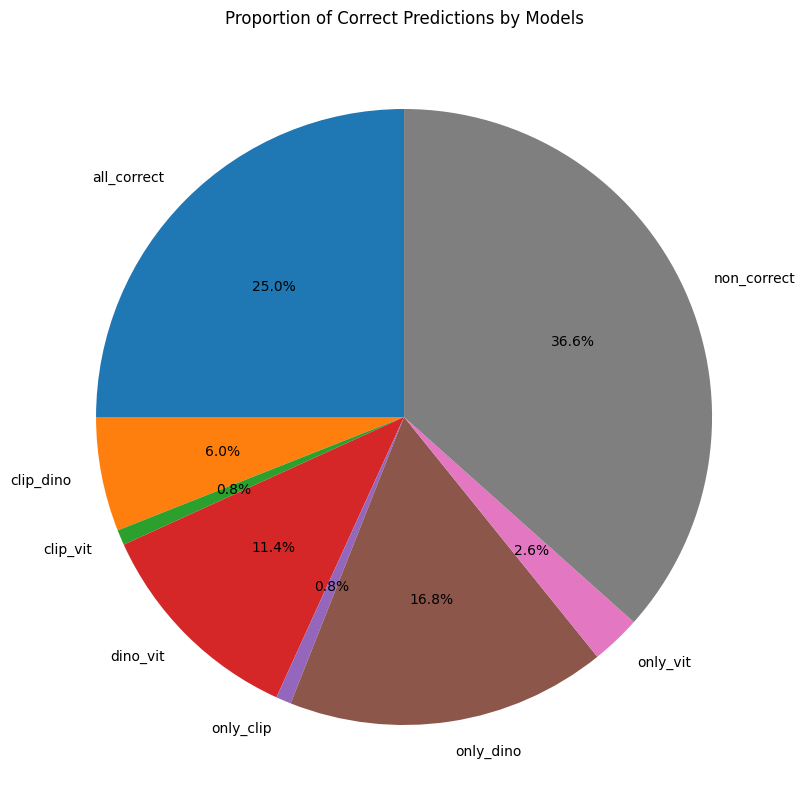

In [89]:
data = [len(all_correct), len(clip_dino), len(clip_vit), len(dino_vit), len(only_clip), len(only_dino), len(only_vit),len(non_correct)]
labels = ['all_correct', 'clip_dino', 'clip_vit', 'dino_vit', 'only_clip', 'only_dino', 'only_vit','non_correct']

# 퍼센트 원형 plot
plt.figure(figsize=(10, 10))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Correct Predictions by Models')
plt.show()

## Semantic anlaysis

## test

In [65]:
def visualize_similar_images_test(query_image_path, retrieved_images):

  fig, axes = plt.subplots(3, 4, figsize=(16, 12))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(3):
      query_image_path = query_image_path
      model_name= retrieved_images[i][0]
      images = retrieved_images[i][1:4]

      query_image = Image.open(query_image_path).convert("RGB")
      axes[i, 0].imshow(query_image)
      axes[i, 0].axis("off")
      axes[i, 0].set_title(f"{model_name}\nQuery Image")

      for col, img_info in enumerate(images, start=1):
          img = Image.open(img_info["path"]).convert("RGB")
          similarity = img_info["similarity"]

          axes[i, col].imshow(img)
          axes[i, col].axis("off")
          axes[i, col].set_title(f"Similarity:\n{similarity:.1f}%")

  plt.tight_layout()
  plt.show()

In [76]:
query_img_path=save_route+'test_image_horse.jpg'

In [68]:
clip_image = clip_processor(images = query_img, return_tensors="pt").pixel_values
clip_image = clip_image.to(device)
clip_features = clip_model.get_image_features(clip_image)
clip_image_features = normalizeL2(clip_features)

dino_image = dino_processor(images = query_img, return_tensors="pt").pixel_values
dino_image = dino_image.to(device)
dino_features = dino_model(dino_image).last_hidden_state.mean(dim=1)
dino_image_features = normalizeL2(dino_features)

vit_image = vit_processor(images = query_img, return_tensors="pt").pixel_values
vit_image = vit_image.to(device)
vit_features = vit_model(vit_image).last_hidden_state.mean(dim=1)
vit_image_features = normalizeL2(vit_features)

In [70]:
index_clip = faiss.read_index(save_route+"clip.index")
index_dino =faiss.read_index(save_route+"dino.index")
index_vit = faiss.read_index(save_route+"vit.index")

In [71]:
d_clip,i_clip = index_clip.search(clip_image_features,3)
d_dino,i_dino = index_dino.search(dino_image_features,3)
d_vit,i_vit = index_vit.search(vit_image_features,3)

In [73]:
retrieved_images_clip = ['clip']+[
    {"path": os.path.join(reference_folder_path,reference_list[int(idx)]+'.jpg'), "similarity": dist* 100} for idx, dist in zip(i_clip[0], d_clip[0])
]
retrieved_images_dino = ["dino"]+[
    {"path": os.path.join(reference_folder_path,reference_list[int(idx)]+'.jpg'), "similarity": dist* 100} for idx, dist in zip(i_dino[0], d_dino[0])
]
retrieved_images_vit = ['vit']+[
    {"path": os.path.join(reference_folder_path,reference_list[int(idx)]+'.jpg'), "similarity": dist* 100} for idx, dist in zip(i_vit[0], d_vit[0])
]
image_index = [retrieved_images_clip,retrieved_images_dino,retrieved_images_vit]

In [77]:
visualize_similar_images_test(query_img_path,image_index)

Output hidden; open in https://colab.research.google.com to view.